# 0.0 IMPORTS

In [1]:
import datetime
import inflection
import json
import math
import matplotlib.gridspec   as gridspec
import matplotlib.pyplot     as plt
import numpy                 as np
import pandas                as pd 
import pickle
import random
import requests
import seaborn               as sns
import warnings
import xgboost               as xgb

from boruta                  import BorutaPy
from IPython.display         import Image
from scipy                   import stats     as ss

from sklearn.ensemble        import RandomForestRegressor
from sklearn.linear_model    import LinearRegression, Lasso
from sklearn.metrics         import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [2]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    k, r = cm.shape
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt( (chi2corr/n) / (min(kcorr-1,rcorr-1)) )

def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
            
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2 Loading Data

In [3]:
df_sales_raw = pd.read_csv( 'Datasets/train.csv' , low_memory=False )
df_store_raw = pd.read_csv( 'Datasets/store.csv' , low_memory=False )

# Merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left' , on='Store' )

# 1.0 Data Description

## 1.1 Rename Columns

In [4]:
#Checkpoint
df1 = df_raw.copy()

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
columns_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

columns_new = list( map(snakecase, columns_old) )

# Rename
df1.columns = columns_new

## 1.2 Data Dimensions

In [7]:
print(f'Number od Rows: {df1.shape[0]}')
print(f'Number od Cols: {df1.shape[1]}')

Number od Rows: 1017209
Number od Cols: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
#Taking the longest distance between competitors
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
#Assumption: NA means a distant competitor. A replacement will be made for a value above the maximum.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#Assumption: The replacement will occur by the value of the month present on the date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year     
#Assumption: The replacement will occur by the value of the year present on the date
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)                          

#promo2_since_week               
#Assumption: The replacement will occur by the value of the week present on the date
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)                          

#promo2_since_year               
#Assumption: The replacement will occur by the value of the week present on the date
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)                          

#promo_interval
#Assumption: Assumption: NA means the store has no active promotion. will be replaced by 0.
#A new feature (is_promo) will be created. In this feature, it will be described if the store has an active promotion.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, meadin
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
descriptive_statistics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

descriptive_statistics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
descriptive_statistics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [17]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

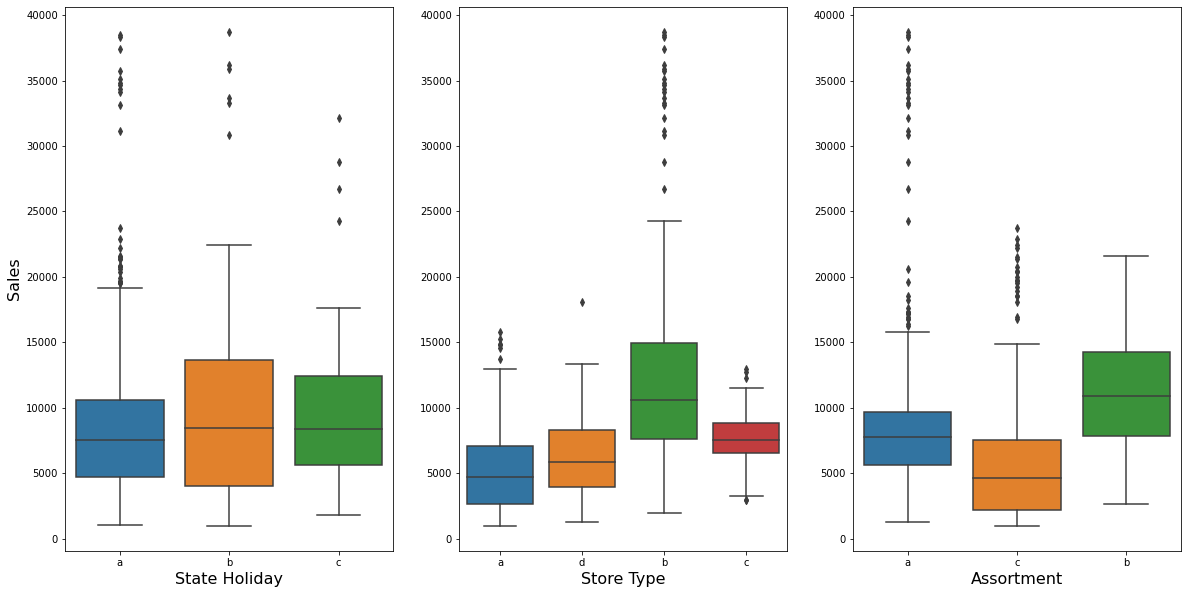

In [18]:
#Filter
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux)
plt.xlabel('State Holiday', size = 16)
plt.ylabel('Sales', size = 16)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux)
plt.xlabel('Store Type', size = 16)
plt.ylabel('', size = 16)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux)
plt.xlabel('Assortment', size = 16)
plt.ylabel('', size = 16)

plt.show()

# 2.0  FEATURE ENGINEERING

In [19]:
df2 = df1.copy()

## 2.1 Hypothesis Mind Map

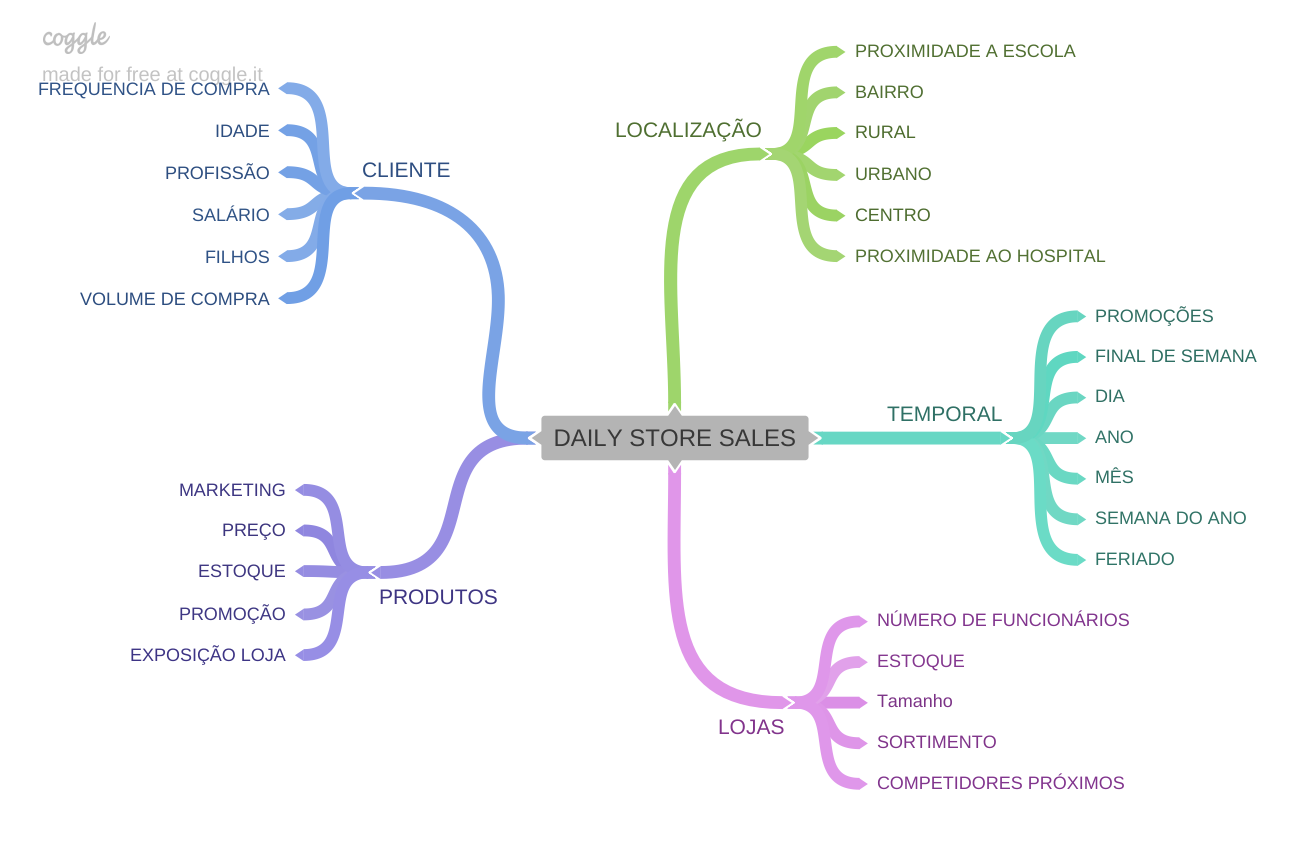

In [20]:
Image('images/mindmap.png')

## 2.2 Hypothesis

### 2.2.1. Hipoteses Loja

    1. Lojas com número maior de funcionários deveriam vender mais.
    2. Lojas com maior capacidade de estoque deveriam vender mais.
    3. Lojas com maior porte deveriam vender mais.
    4. Lojas com maior sortimento deveriam vender mais.
    5. Lojas com competidores mais próximos deveriam vender menos.
    6. Lojas com competidores a mais tempo deveriam vendem mais.
    
### 2.2.2. Hipoteses Produto

    1. Lojas que investem mais em Marketing deveriam vender mais.
    2. Lojas com maior exposição de produto deveriam vender mais.
    3. Lojas com produtos com preço menor deveriam vender mais.
    4. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
    5. Lojas com promoções ativas por mais tempo deveriam vender mais.
    6. Lojas com mais dias de promoção deveriam vender mais.
    7. Lojas com mais promoções consecutivas deveriam vender mais.
    
### 2.2.3. Hipoteses Tempo
    
    1. Lojas abertas durante o feriado de Natal deveriam vender mais.
    2. Lojas deveriam vender mais ao longo dos anos.
    3. Lojas deveriam vender mais no segundo semestre do ano.
    4. Lojas deveriam vender mais depois do dia 10 de cada mês.
    5. Lojas deveriam vender menos aos finais de semana.
    6. Lojas deveriam vender menos durante os feriados escolares.
  

## 2.3. Lista Final de Hipóteses
   

    1. Lojas com maior sortimento deveriam vender mais.
    2. Lojas com competidores mais próximos deveriam vender menos.
    3. Lojas com competidores a mais tempo deveriam vendem mais.
    4. Lojas com promoções ativas por mais tempo deveriam vender mais.
    5. Lojas com mais promoções consecutivas deveriam vender mais.
    6. Lojas abertas durante o feriado de Natal deveriam vender mais.
    7. Lojas deveriam vender mais ao longo dos anos.
    8. Lojas deveriam vender mais no segundo semestre do ano.
    9. Lojas deveriam vender mais depois do dia 10 de cada mês.
    10. Lojas deveriam vender menos aos finais de semana.
    11. Lojas deveriam vender menos durante os feriados escolares
    

## 2.4 Feature Engineering

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#Competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'Public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day' )

# 3.0 FILTERING VARIABLES

In [22]:
df3 = df2.copy()

## 3.1 Line filtering

In [23]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Columns selection

In [24]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 EDA

In [25]:
df4 = df3.copy()

In [26]:
num_attributes_eda = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes_eda = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

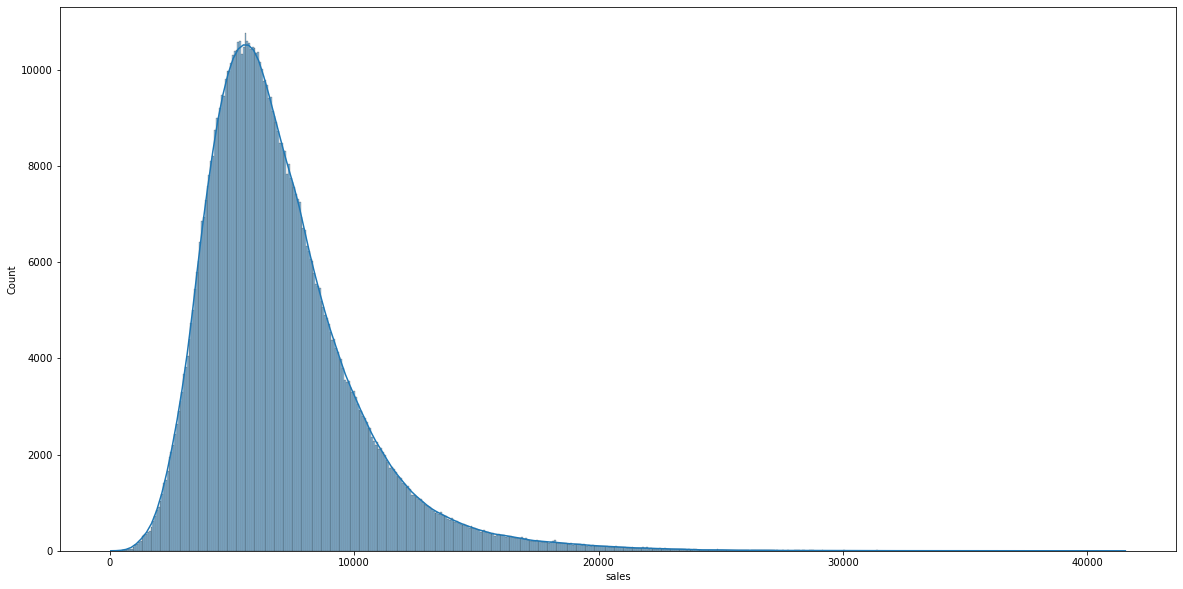

In [27]:
plt.figure(figsize=(20,10))
sns.histplot(df4['sales'], kde = True)
plt.show()

### 4.1.2 Numerical Variable

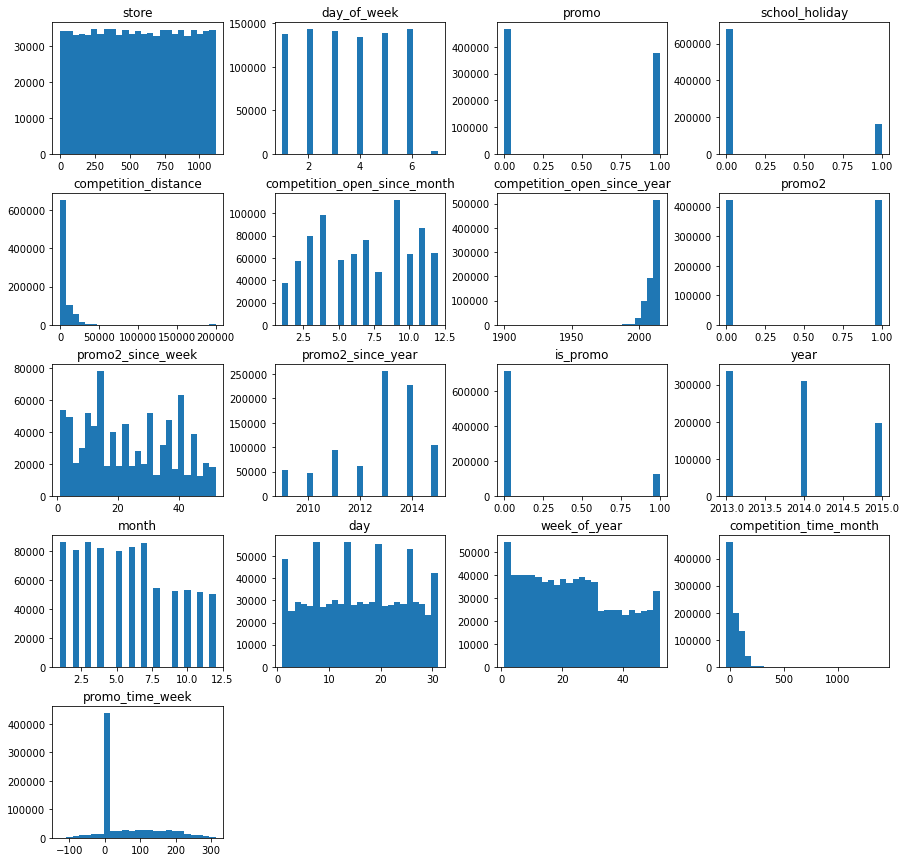

In [28]:
num_attributes_eda = num_attributes_eda.drop('sales', axis=1)
num_attributes_eda.hist(bins = 25, figsize = (15,15), grid= False);

### 4.1.3 Categorical Variable

In [29]:
cat_attributes_eda['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

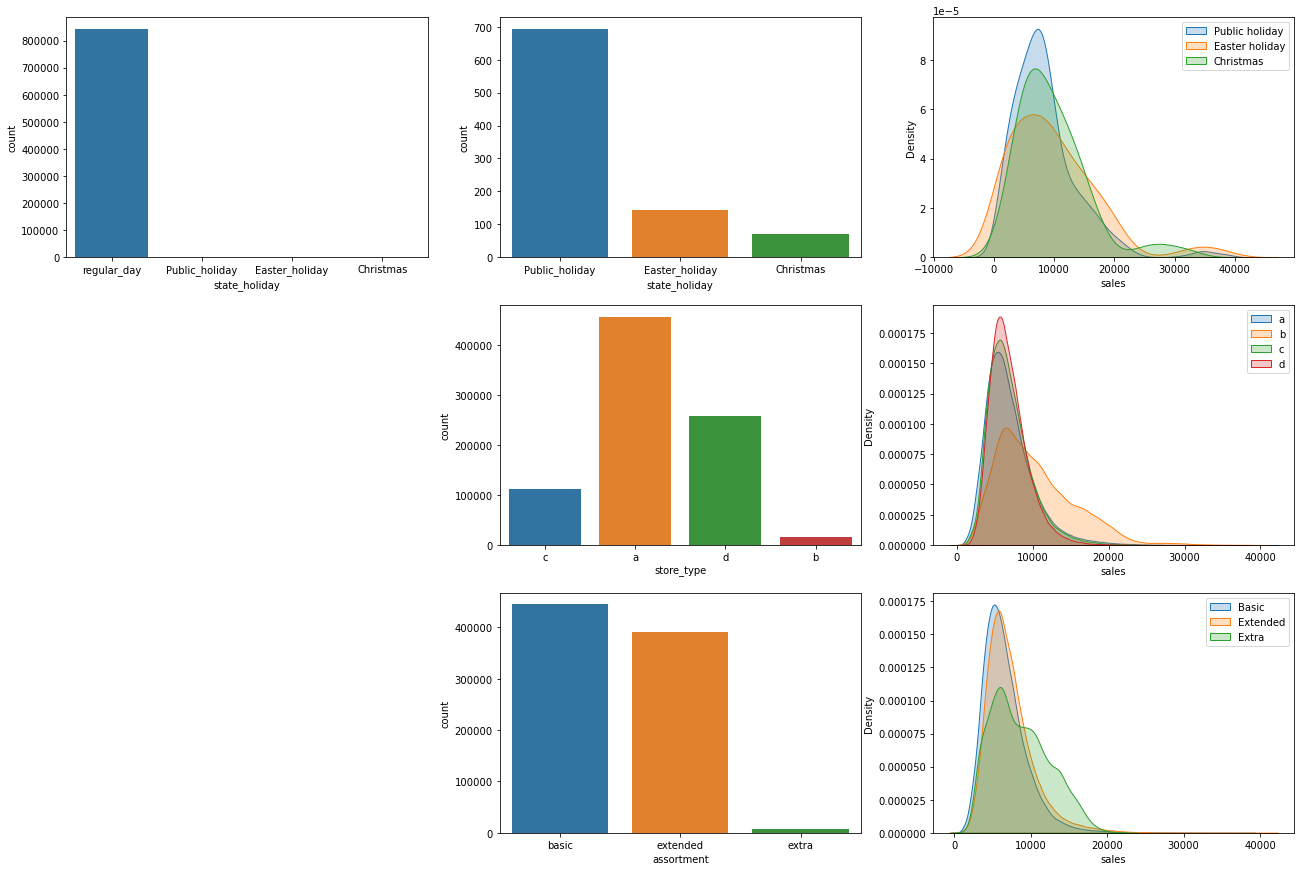

In [30]:
plt.figure(figsize=(22,15))

plt.subplot(3,3,1)
sns.countplot(data = cat_attributes_eda, x= 'state_holiday');

plt.subplot(3,3,2)
aux = cat_attributes_eda[cat_attributes_eda['state_holiday'] != 'regular_day']
sns.countplot(data = aux, x= 'state_holiday');

plt.subplot(3,3,3)
sns.kdeplot( df4[df4['state_holiday'] == 'Public_holiday']['sales'], label='Public holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'Easter_holiday']['sales'], label='Easter holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', shade=True )
plt.legend()

plt.subplot(3,3,5)
sns.countplot(data = cat_attributes_eda, x= 'store_type');

plt.subplot(3,3,6)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True )
plt.legend()

plt.subplot(3,3,8)
sns.countplot(data = cat_attributes_eda, x= 'assortment');

plt.subplot(3,3,9)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='Basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='Extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='Extra', shade=True )
plt.legend()

plt.show()

## 4.2 Bivariate analysis

### H1. Lojas com maior sortimento deveriam vender mais.

**VERDADEIRA:** Lojas com maior sortimento vendem, em média, **mais**.

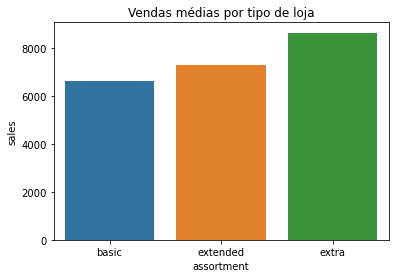

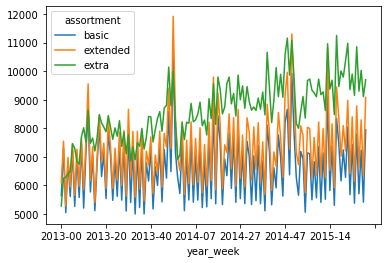

In [31]:
plt.title('Vendas médias por tipo de loja')
aux1_h1 = df4[['sales','assortment']].groupby('assortment').mean().reset_index()
sns.barplot(data = aux1_h1, x= 'assortment', y='sales');

aux2_h1 = df4[['sales','assortment','year_week']].groupby(['assortment','year_week']).mean().reset_index()
aux2_h1.pivot( index='year_week', columns='assortment', values='sales').plot();

#aux3_h1 = aux2_h1[aux2_h1['assortment'] == 'extra']
#aux3_h1.pivot( index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA:** Lojas com competidores mais próximos vendem **mais**.

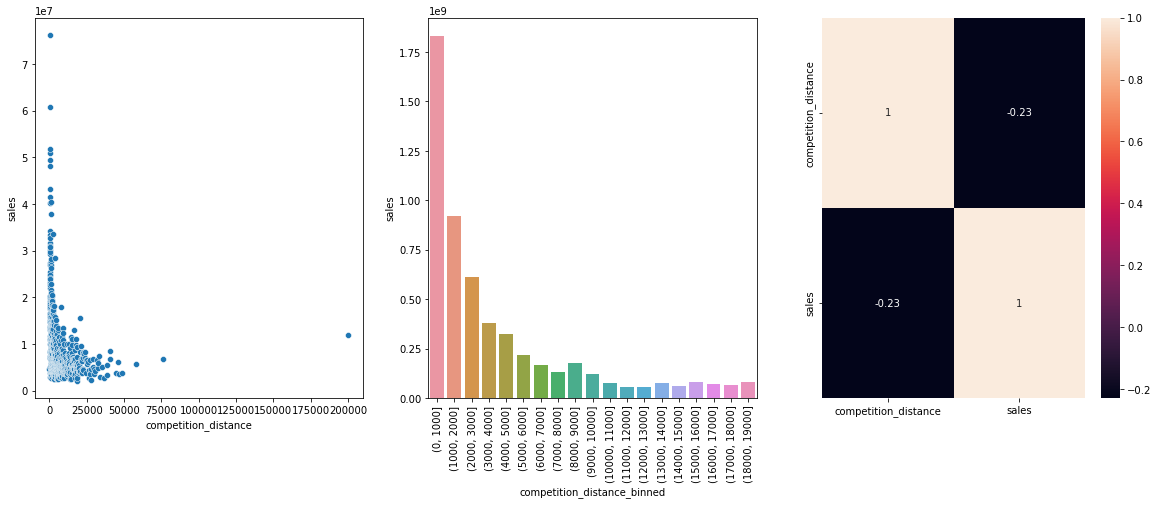

In [32]:
plt.figure (figsize=(20,7))

plt.subplot(1,3,1)
aux1_h2 = df4[['sales','competition_distance']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x= 'competition_distance', y= 'sales', data = aux1_h2)

plt.subplot(1,3,2)
bins = np.arange(0, 20000, 1000)
aux1_h2['competition_distance_binned'] = pd.cut(aux1_h2['competition_distance'], bins=bins)
aux2_h2 = aux1_h2[['sales','competition_distance_binned']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(data = aux2_h2, x='competition_distance_binned', y='sales');
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1_h2.corr('pearson'), annot = True);

### H3. Lojas com competidores a mais tempo deveriam vendem mais.

**FALSA:** Lojas com competidores a mias tempo vendem **menos**

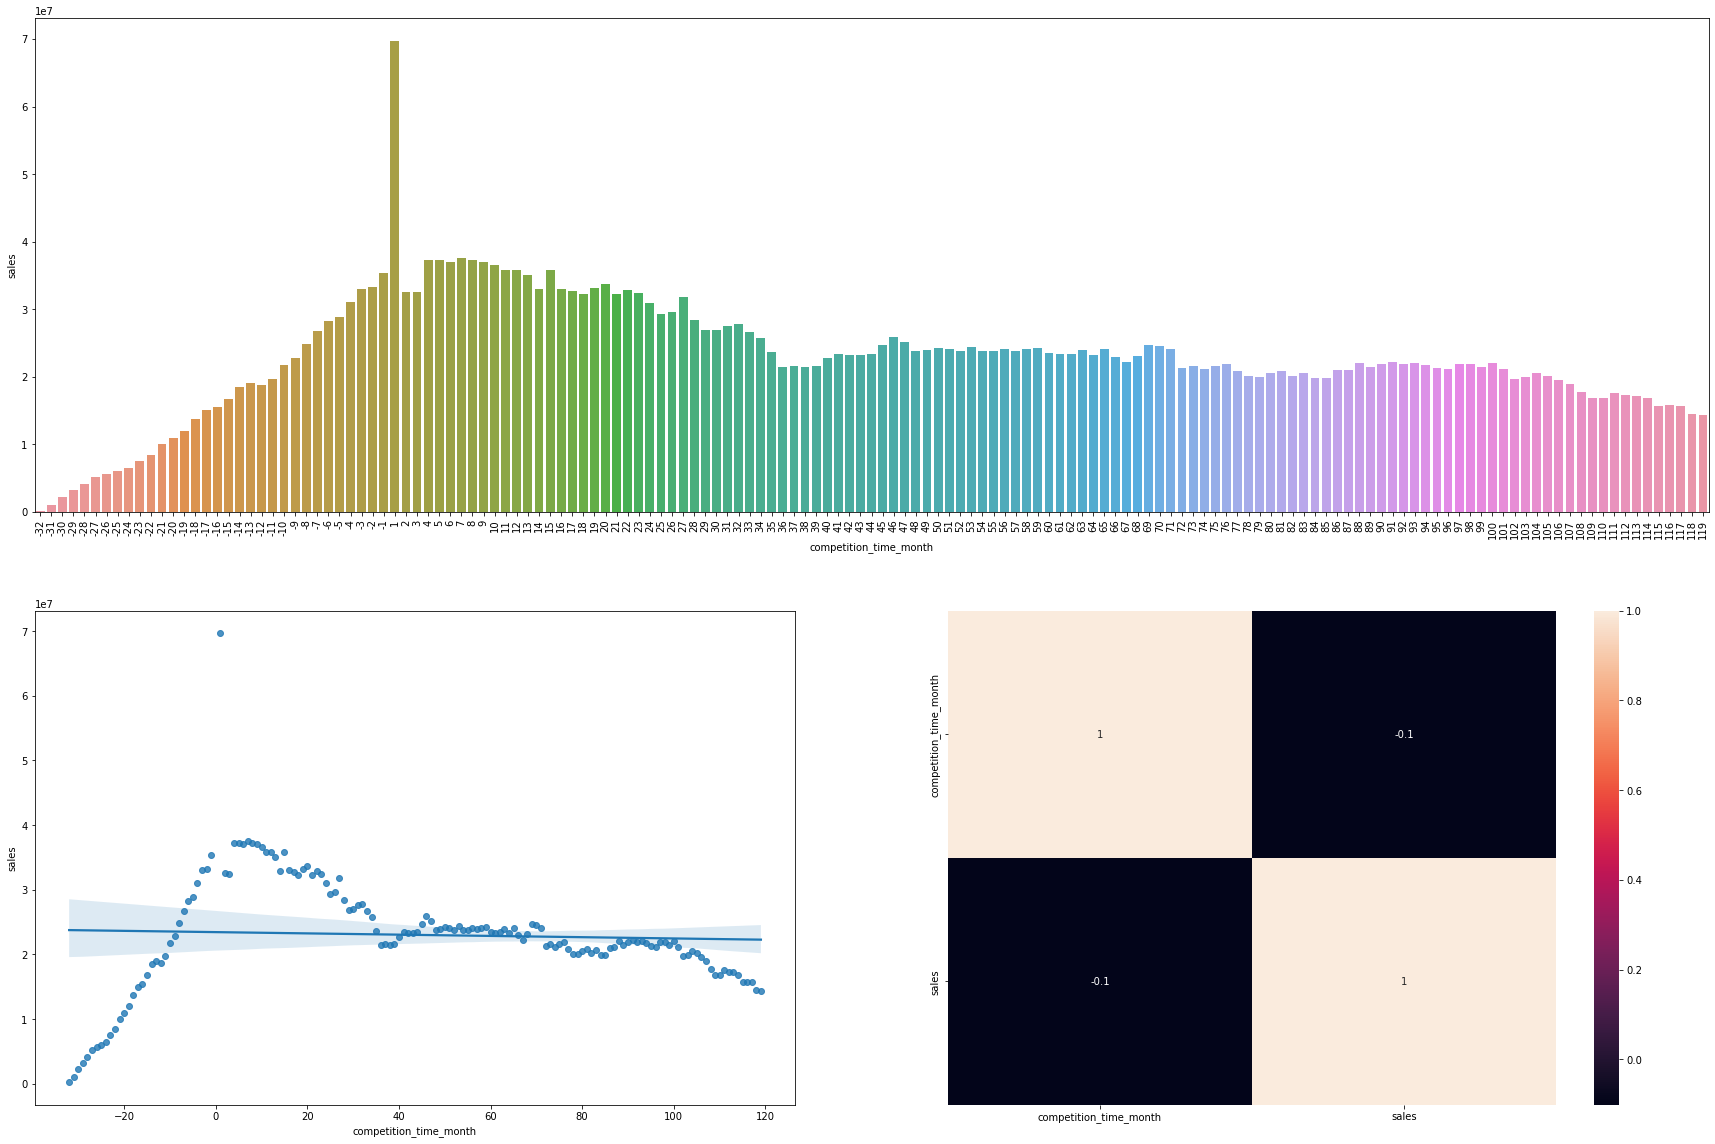

In [33]:
plt.figure(figsize=(30,20))
G = gridspec.GridSpec(2,2)

plt.subplot(G[0, :])
aux1_h3 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2_h3 = aux1_h3[(aux1_h3['competition_time_month'] < 120) & (aux1_h3['competition_time_month'] != 0)]
sns.barplot(data = aux2_h3, x='competition_time_month', y='sales');
plt.xticks(rotation = 90);

plt.subplot(G[1, 0])
sns.regplot(data = aux2_h3, x='competition_time_month', y='sales');

plt.subplot(G[1, 1])
sns.heatmap(aux1_h3.corr('pearson'), annot = True);

### 4. Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA:** Lojas com promoções ativas por mais tempo vendem menos depois de um certo tempo de promoção.


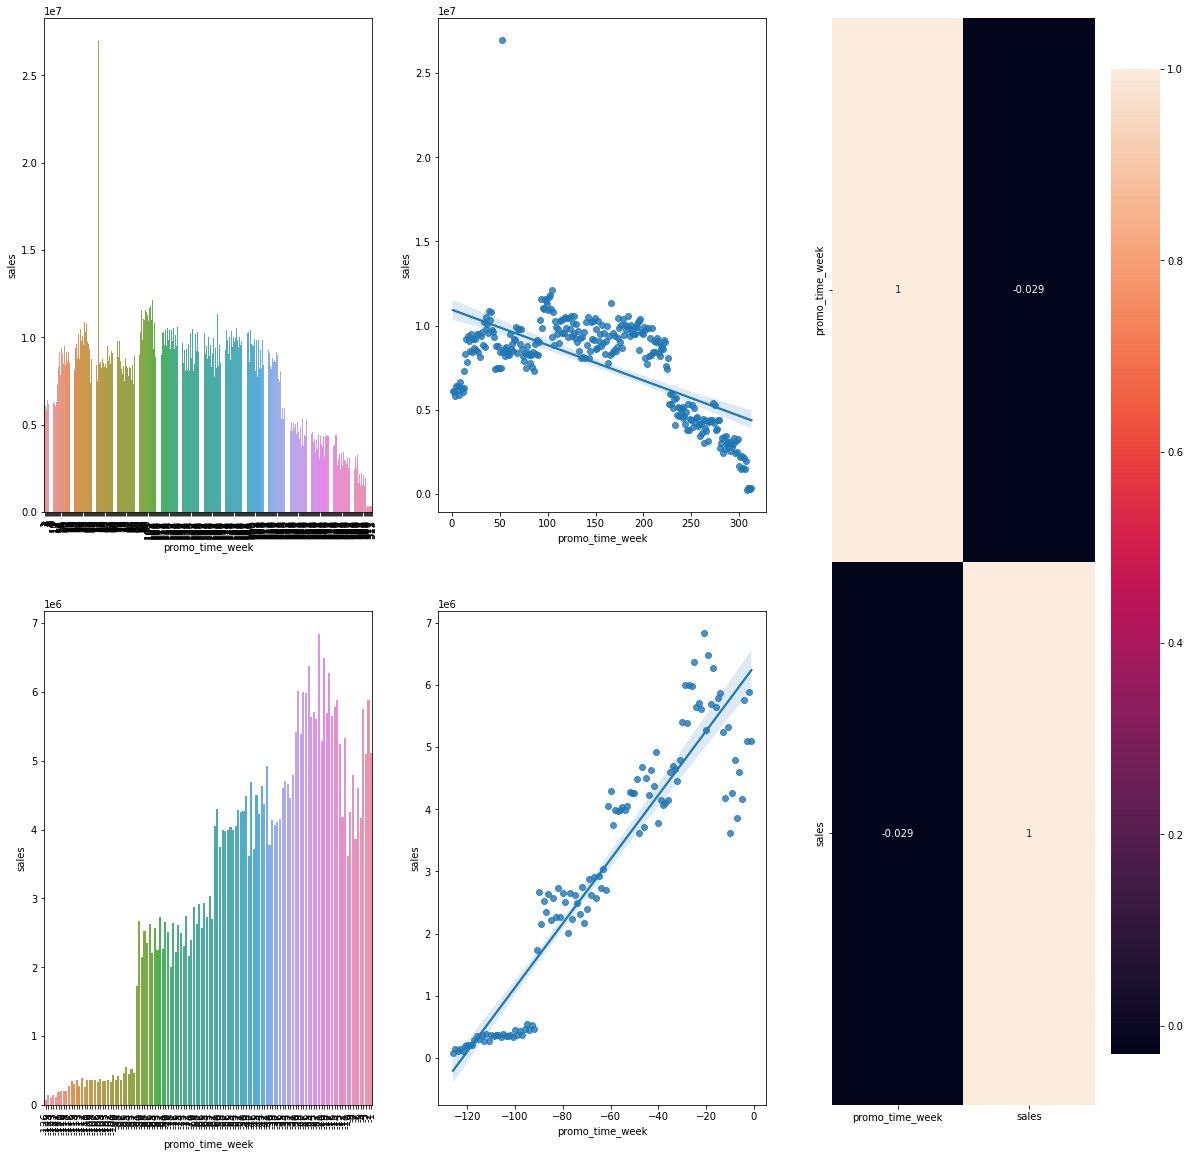

In [34]:
G = gridspec.GridSpec(2,3)
plt.figure(figsize=(20,20))
aux1_h4 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(G[0,0])
aux2_h4 = aux1_h4[aux1_h4['promo_time_week'] > 0] #promoção extendida 
sns.barplot(data = aux2_h4, x = 'promo_time_week', y= 'sales');
plt.xticks(rotation = 90);

plt.subplot(G[0,1])
sns.regplot(data = aux2_h4, x = 'promo_time_week', y= 'sales');

plt.subplot(G[1,0])
aux3_h4 = aux1_h4[aux1_h4['promo_time_week'] < 0] #promoção regular 
sns.barplot(data = aux3_h4, x = 'promo_time_week', y= 'sales');
plt.xticks(rotation = 90);

plt.subplot(G[1,1])
sns.regplot(data = aux3_h4, x = 'promo_time_week', y= 'sales');

plt.subplot(G[:,2])
sns.heatmap(aux1_h4.corr('pearson'), annot = True);

### 5. Lojas com mais promoções consecutivas deveriam vender mais.


**FALSA:** Lojas com promoções consecutivas vendem **menos**. 

In [35]:
#Agrupamento das variáveis promocionais (promo e promo2) e ordenamento em função das vendas (sales)
aux1_h5 = df4[['promo','sales','promo2']].groupby(['promo','promo2']).sum().reset_index()
aux1_h5.sort_values(by=['sales'], ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


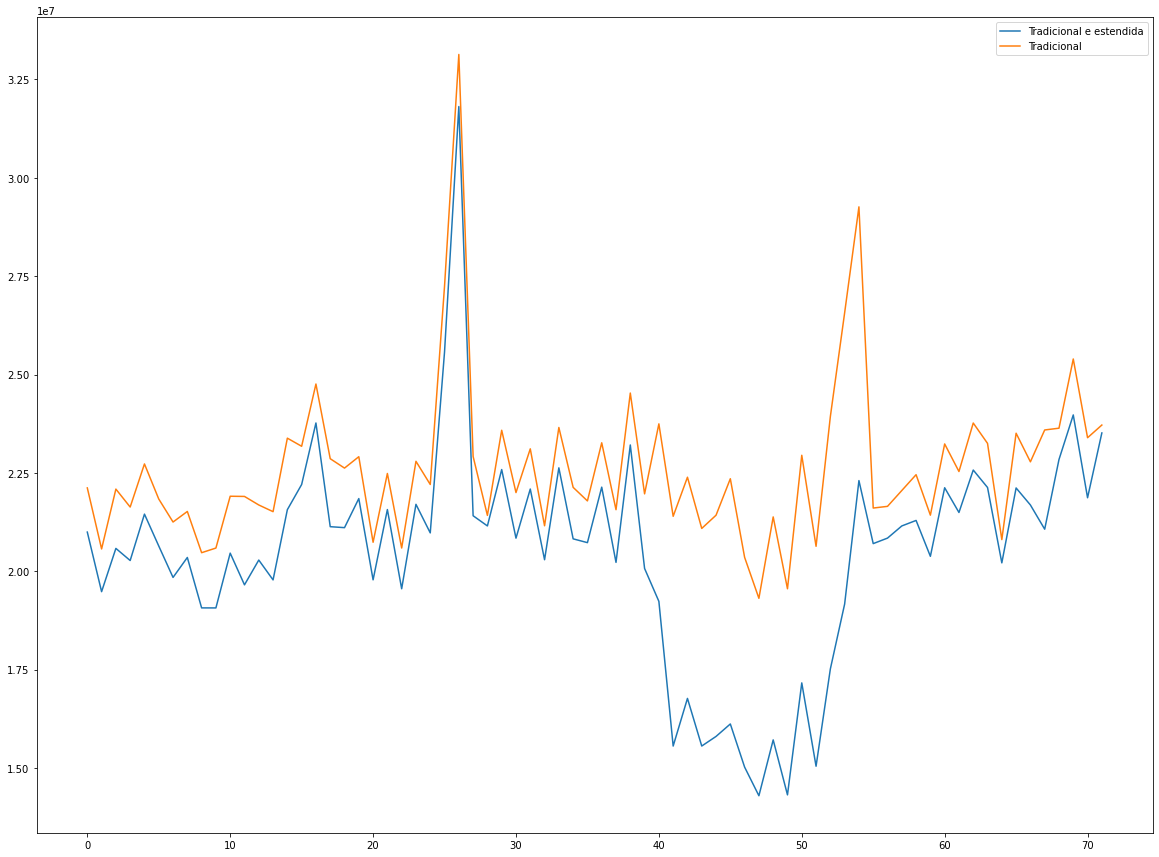

In [36]:
aux3_h5 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['sales','year_week']].groupby('year_week').sum().reset_index()
ax = aux3_h5.plot()

aux4_h5 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['sales','year_week']].groupby('year_week').sum().reset_index()
aux4_h5.plot(ax=ax, figsize = (20,15))

ax.legend(labels=['Tradicional e estendida', 'Tradicional'])
plt.show()

## 6. Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA:** Lojas durante o natal vendem **menos**.

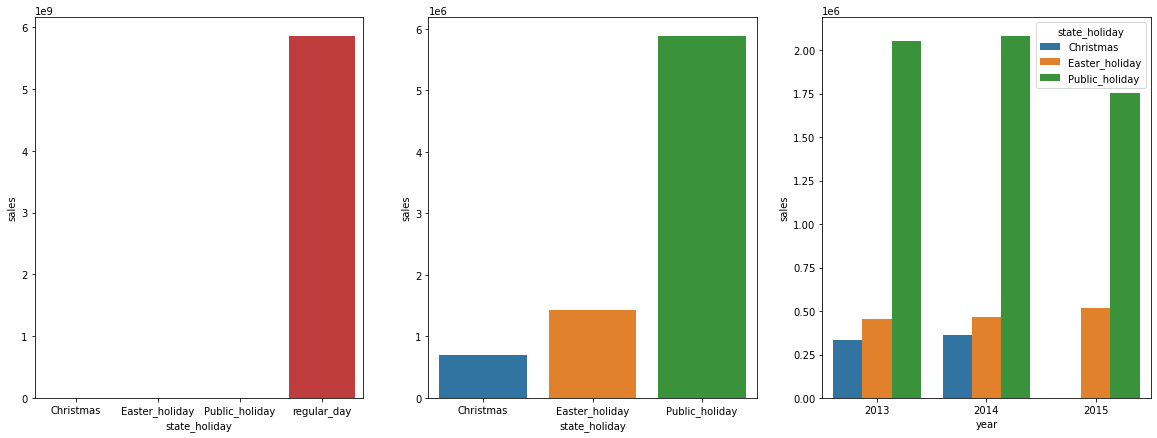

In [37]:
plt.figure(figsize=(20,7))

plt.subplot(1,3,1)
aux1_h6 = df4[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data = aux1_h6, x = 'state_holiday', y= 'sales');

plt.subplot(1,3,2)
aux2_h6 = aux1_h6[aux1_h6['state_holiday'] != 'regular_day']
sns.barplot(data = aux2_h6, x = 'state_holiday', y= 'sales');

plt.subplot(1, 3, 3)
aux3_h6 = df4[df4['state_holiday'] != 'regular_day']
aux4_h6 = aux3_h6[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux4_h6 );

## 7. Lojas deveriam vender mais ao longo dos anos.

**FALSA:** As lojas venderam menos ao longo dos anos 

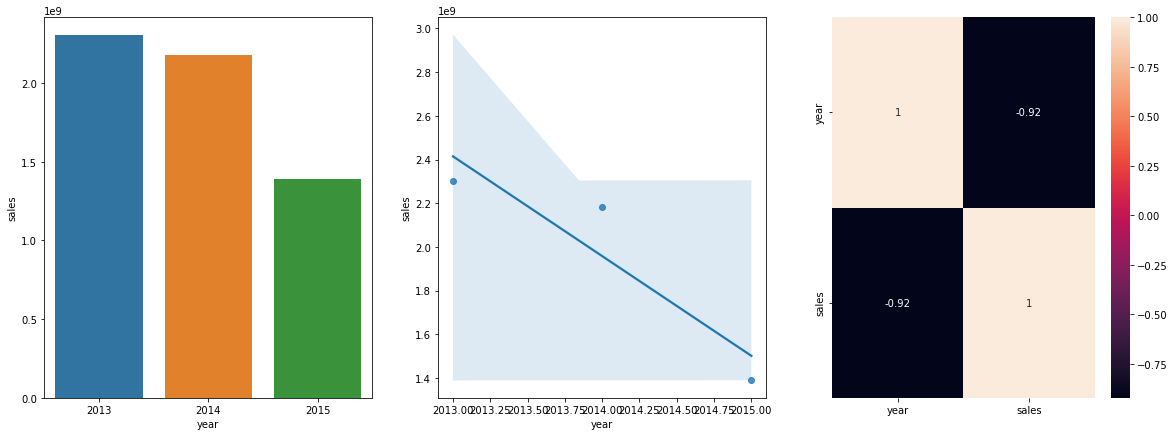

In [38]:
plt.figure(figsize=(20,7))

plt.subplot(1, 3, 1)
aux1_h7 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(data = aux1_h7, x = 'year', y= 'sales');

plt.subplot(1, 3, 2)
sns.regplot(data = aux1_h7, x = 'year', y= 'sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux1_h7.corr(method = 'pearson'), annot = True);

## 8. Lojas deveriam vender mais no segundo semestre do ano.

**VERDADEIRA:** A média de venda das lojas no segundo ano é maior.

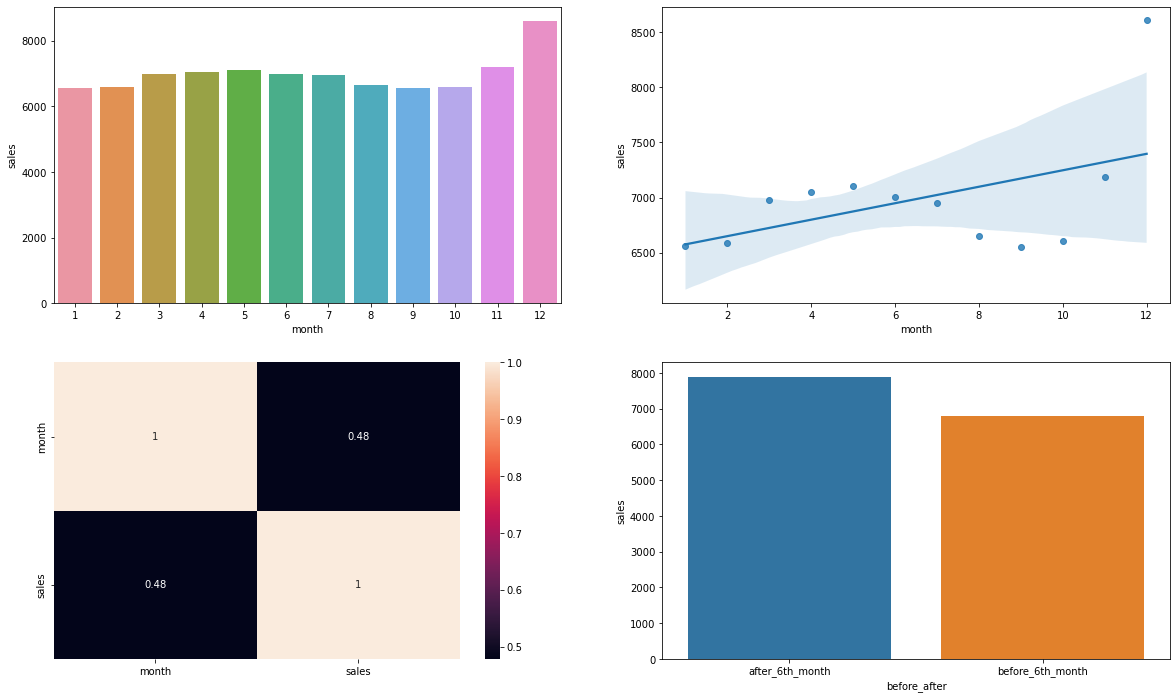

In [39]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
aux1_h8 = df4[['month','sales']].groupby('month').mean().reset_index()
sns.barplot(data = aux1_h8, x = 'month', y= 'sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux1_h8, x = 'month', y= 'sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1_h8.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1_h8['before_after'] = aux1_h8['month'].apply(lambda x: 'before_6th_month' if x <= 10 else 'after_6th_month')
aux2_h8 = aux1_h8[['sales', 'before_after']].groupby('before_after').mean().reset_index()
sns.barplot(data = aux2_h8, x= 'before_after', y='sales');

## 9. Lojas deveriam vender mais depois do dia 10 de cada mês.

**FALSA:** A venda média das lojas antes do dia 10 é superior à média depois do dia 10.

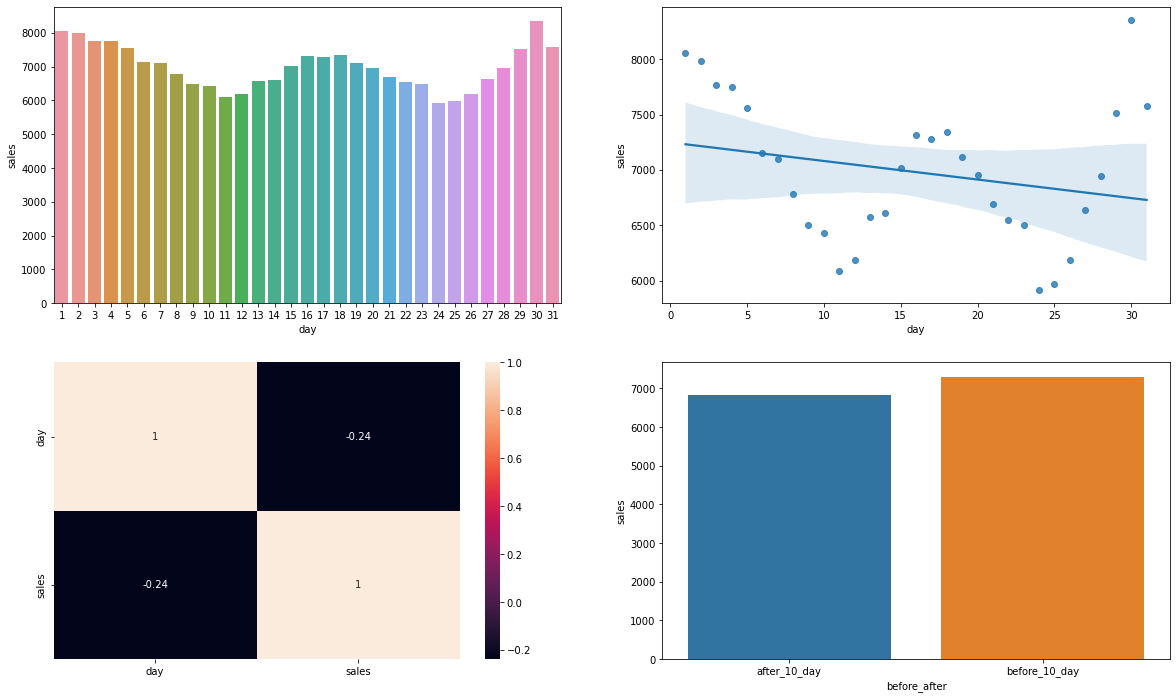

In [40]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
aux1_h9 = df4[['day','sales']].groupby('day').mean().reset_index()
sns.barplot(data = aux1_h9, x = 'day', y= 'sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux1_h9, x = 'day', y= 'sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1_h9.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1_h9['before_after'] = aux1_h9['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2_h9 = aux1_h9[['sales', 'before_after']].groupby('before_after').mean().reset_index()
sns.barplot(data = aux2_h9, x= 'before_after', y='sales');

## 10. Lojas deveriam vender menos aos finais de semana

**VERDADEIRA:** As lojas vendem menos aos finais de semana.

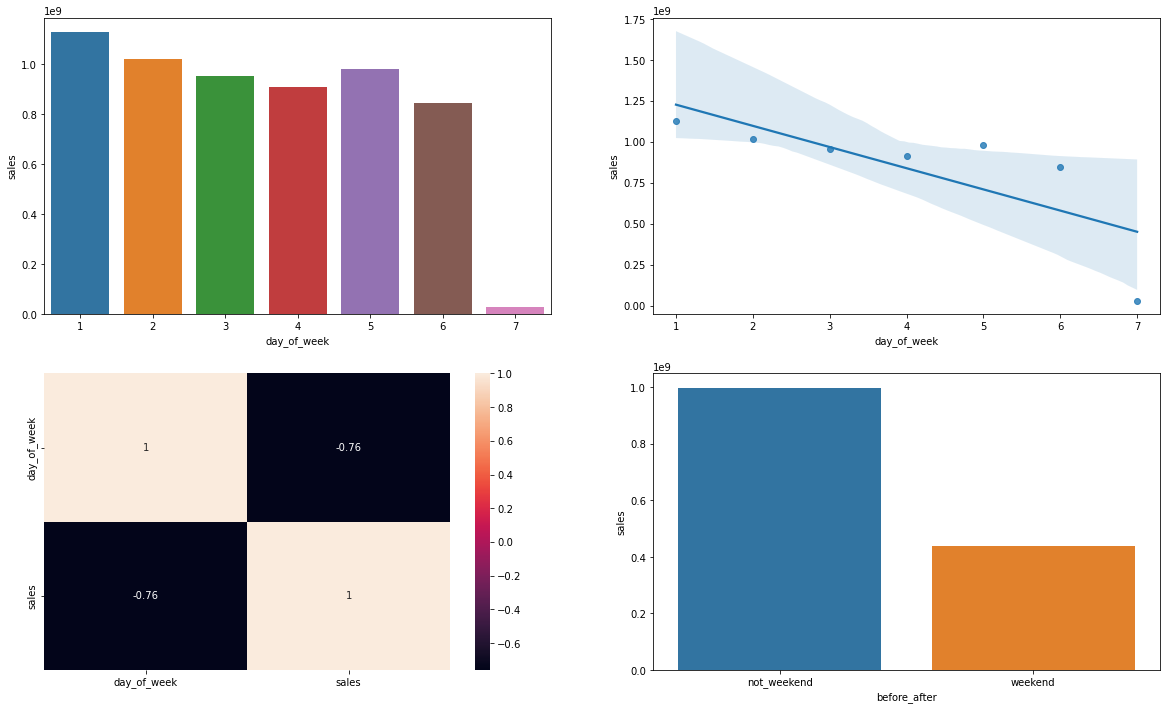

In [41]:
plt.figure(figsize=(20,12))

plt.subplot(2, 2, 1)
aux1_h10 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(data = aux1_h10, x = 'day_of_week', y= 'sales');

plt.subplot(2, 2, 2)
sns.regplot(data = aux1_h10, x = 'day_of_week', y= 'sales');

plt.subplot(2, 2, 3)
sns.heatmap(aux1_h10.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1_h10['before_after'] = aux1_h10['day_of_week'].apply(lambda x: 'not_weekend' if x <= 5 else 'weekend')
aux2_h10 = aux1_h10[['sales', 'before_after']].groupby('before_after').mean().reset_index()
sns.barplot(data = aux2_h10, x= 'before_after', y='sales');

## 11. Lojas deveriam vender menos durante os feriados escolares

**VERDADEIRA:** As lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto. 

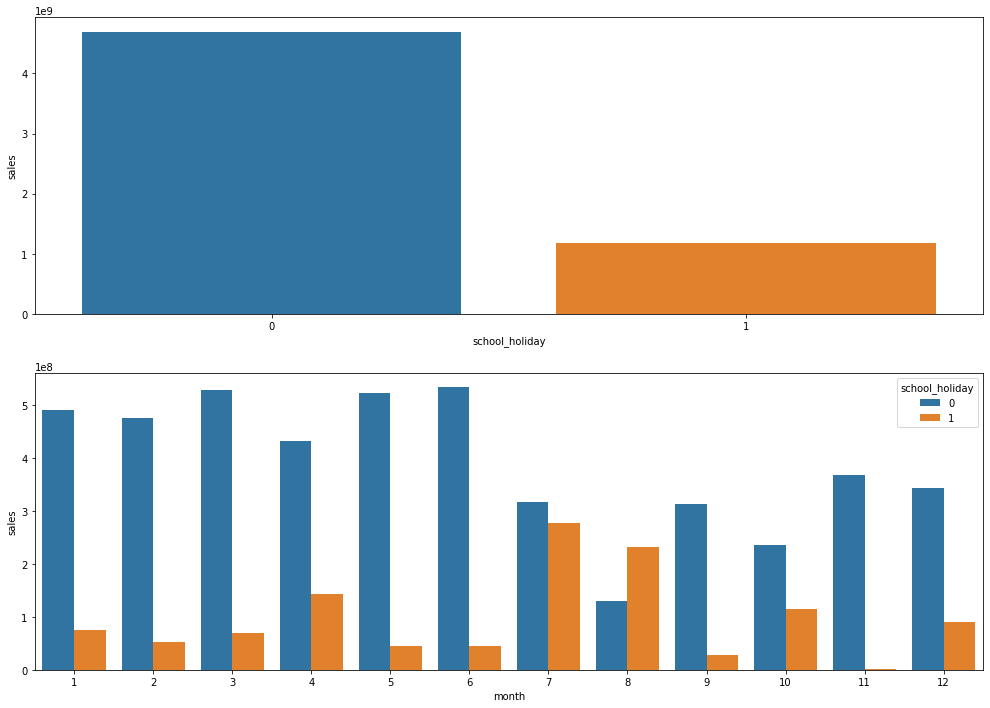

In [42]:
plt.figure(figsize=(17,12))

plt.subplot(2, 1, 1)
aux1_h11 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(data = aux1_h11, x = 'school_holiday', y= 'sales');

plt.subplot(2, 1, 2)
aux1_h11 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(data = aux1_h11, x = 'month', y= 'sales', hue='school_holiday');

## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

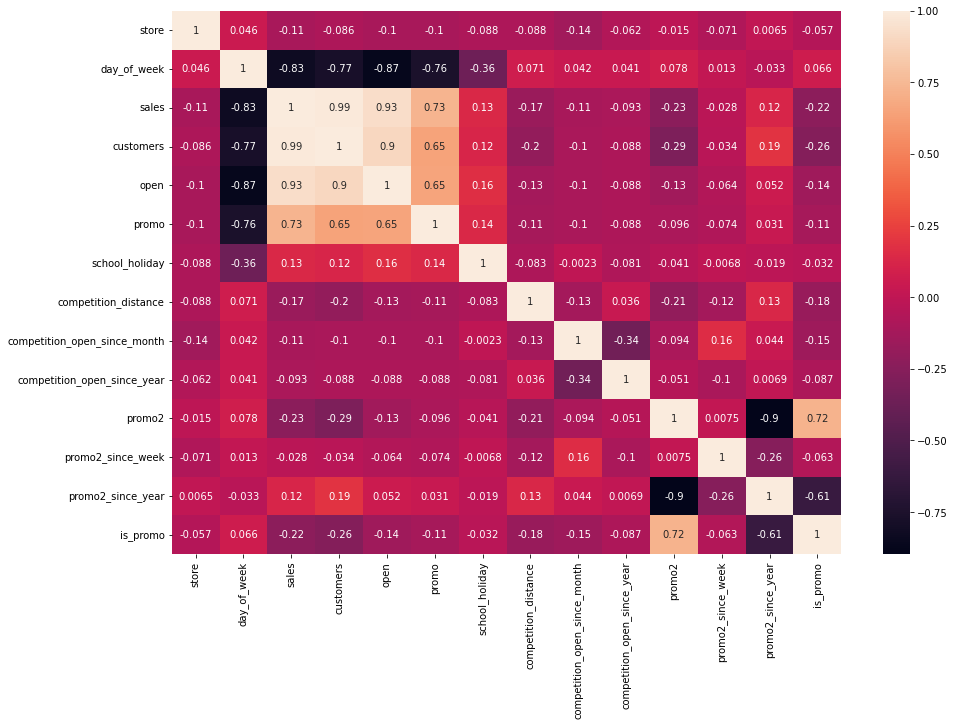

In [43]:
corr_numerical = num_attributes.corr(method = 'pearson')
plt.figure(figsize=(15,10))
sns.heatmap(corr_numerical.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes

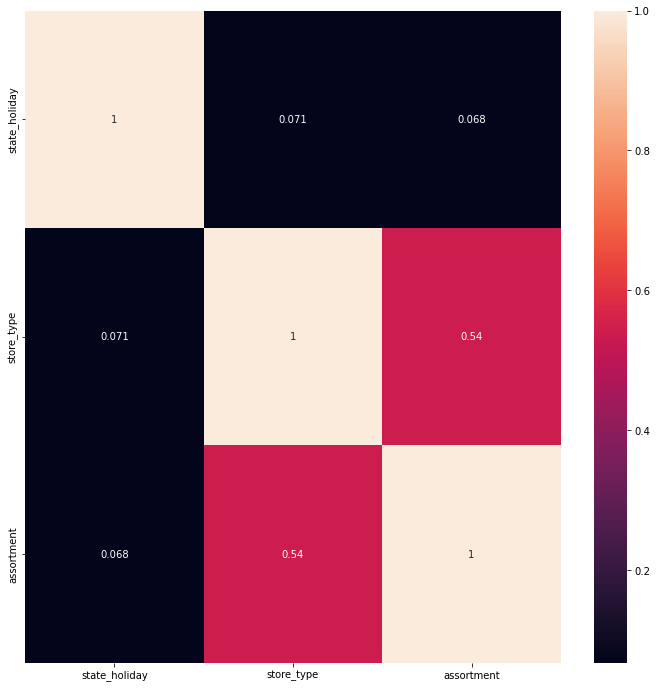

In [44]:
# Only categorical data
aux_432 = df4.select_dtypes(include = 'object')

# Calculate Cramer V

a1 = cramer_v(aux_432['state_holiday'], aux_432['state_holiday'])
a2 = cramer_v(aux_432['state_holiday'], aux_432['store_type'])
a3 = cramer_v(aux_432['state_holiday'], aux_432['assortment'])

a4 = cramer_v(aux_432['store_type'], aux_432['state_holiday'])
a5 = cramer_v(aux_432['store_type'], aux_432['store_type'])
a6 = cramer_v(aux_432['store_type'], aux_432['assortment'])

a7 = cramer_v(aux_432['assortment'], aux_432['state_holiday'])
a8 = cramer_v(aux_432['assortment'], aux_432['store_type'])
a9 = cramer_v(aux_432['assortment'], aux_432['assortment'])

# Final dataset

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type':    [a4, a5, a6],
               'assortment':    [a7, a8, a9] } )
d = d.set_index( d.columns)

# Create Heatmap

plt.figure(figsize=(12,12))
sns.heatmap( d, annot=True );

# 5.0 Data Preparation

In [45]:
df5 = df4.copy()

## 5.1 Normalização

#### Como nenhuma das variáveis apresenta uma distribuição normal, vamos direto para o Rescaling.

## 5.2 Rescalling

In [46]:
aux_52 = df5.select_dtypes(include = ['int64','float64'])

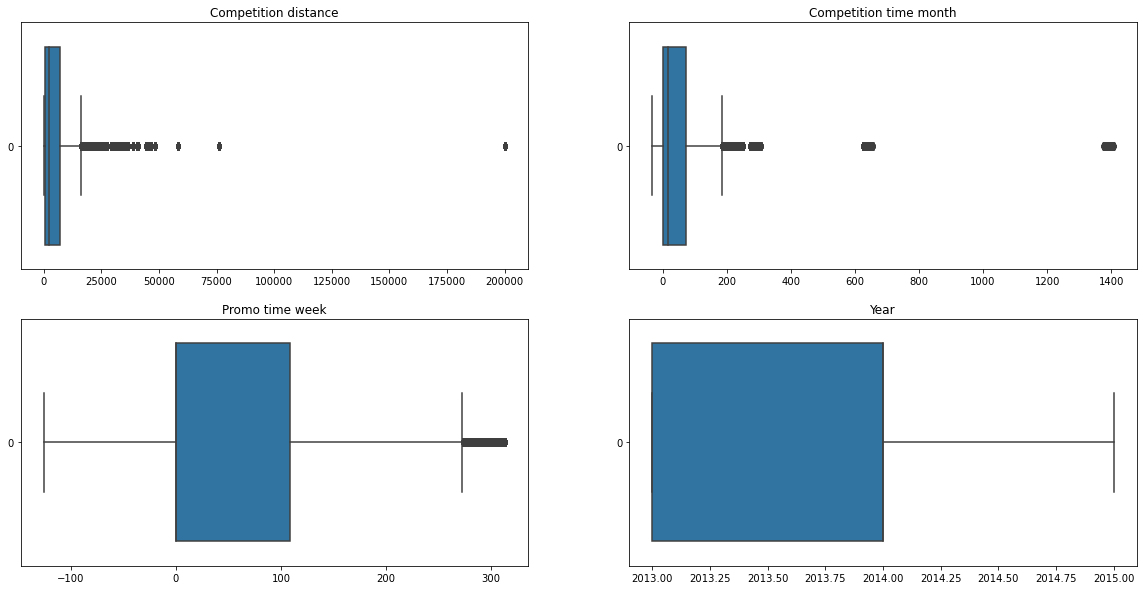

In [47]:
plt.figure(figsize=(20,10))

plt.subplot(2,2,1)
plt.title('Competition distance')
sns.boxplot(data = df5['competition_distance'], orient = 'h');

plt.subplot(2,2,2)
plt.title('Competition time month')
sns.boxplot(data = df5['competition_time_month'], orient = 'h');

plt.subplot(2,2,3)
plt.title('Promo time week')
sns.boxplot(data = df5['promo_time_week'], orient = 'h');

plt.subplot(2,2,4)
plt.title('Year')
sns.boxplot(data = df5['year'], orient = 'h');

In [48]:
rs = RobustScaler() #Para outliers significativos
mms = MinMaxScaler() #Para outliers não significativo

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# year 
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl', 'wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [49]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [50]:
# Mudando para a base log
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [51]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

In [52]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_Public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [54]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [55]:
#Data com  venda mais antiga
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [56]:
#Data com venda mais recente
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=42)

Timestamp('2015-06-19 00:00:00')

<b>Hipótese:</b> As últimas 6 semanas de vendas disponíveis no dataset serão separadas como teste. As demais como treino.  
O cálculo foi apresentado anteriomente

In [57]:
# Training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print(f'Training Min Date: {X_train["date"].min()}')
print(f'Training Max Date: {X_train["date"].max()}')
print('\n')
print(f'Test Min Date: {X_test["date"].min()}')
print(f'Test Max Date: {X_test["date"].max()}')

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00


Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Borutra as Feature Selection

In [58]:
# Training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#Y_train_n = Y_train.values.ravel()

# Define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

# Define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, Y_train_n )

### 6.2.1 Best Features from Boruta

In [59]:
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1 )
#cols_selected = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Not Selected Boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train+fs.columns, cols_selected_boruta ) )

## 6.3 Manual Feature Selection

In [60]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [61]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average model

In [62]:
aux1_71 = x_test.copy()
aux1_71['sales'] = Y_test.copy()

#prediction
aux2_71 = aux1_71[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1_71 = pd.merge(aux1_71 , aux2_71, how='left', on='store')
yhat_baseline = aux1_71['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression model

In [63]:
#model
lr = LinearRegression().fit(x_train, Y_train)

#prediction
yhat_lr = lr.predict(x_test)


#performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression model - Cross Validation

In [64]:
lr_result_cv = cross_validation(x_training, kfold = 5, model_name = 'Linear Regression', model = lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized model - Lasso

In [65]:
#model
lasso = Lasso(alpha=0.01).fit(x_train, Y_train)

#prediction
yhat_lasso = lasso.predict(x_test)


#performance
lasso_result = ml_error('Lasso Regression', np.expm1(Y_test), np.expm1(yhat_lasso))
lasso_result

,Model Name,MAE,MAPE,RMSE
0,Lasso Regression,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized model - Lasso - Cross Validation

In [66]:
lasso_result_cv = cross_validation(x_training, kfold = 5, model_name = 'Lasso Regression', model = lasso, verbose=False)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Radom Forest Regressor

In [67]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state = 42).fit(x_train, Y_train)

#prediction
yhat_rf = rf.predict(x_test)


#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1 Radom Forest Regressor - Cross Validation

In [68]:
rf_result_cv = cross_validation(x_training, kfold = 5, model_name = 'Random Forest Regressor', model = rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [69]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7).fit(x_train, Y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,879.438036,0.127125,1297.682812


### 7.5.1 XGBoost Regressor - Cross Validation

In [70]:
xgb_result_cv = cross_validation(x_training, kfold = 5, model_name = 'XGBoost Regressor', model = model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1044.6 +/- 163.83,0.14 +/- 0.02,1506.89 +/- 220.85


## 7.6 Compare Model's Performance

### 7.6.1. Single Performance

In [71]:
modeling_result = pd.concat([baseline_result, lr_result, lasso_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,XGBoost Regressor,879.438036,0.127125,1297.682812
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Lasso Regression,1891.704881,0.289106,2744.451737


### 7.6.2. Performance with Cross Validation

In [72]:
modeling_result_cv = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])
modeling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,1044.6 +/- 163.83,0.14 +/- 0.02,1506.89 +/- 220.85


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [73]:
# param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#          'eta': [0.01, 0.03],
#          'max_depth': [3, 5, 9],
#          'subsample': [0.1, 0.5, 0.7],
#          'colsample_bytree': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 8, 15]
#         }

# MAX_EVAL = 5

In [74]:
# final_result = pd.DataFrame()

# #model
# for i in range (MAX_EVAL):
    
#     # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
    
#     #model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  min_child_weight = hp['min_child_weight']
#                                 )

#     #performance
#     result_cv_hft = cross_validation(x_training, kfold = 5, model_name = 'XGBoost Regressor HFT', model = model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result_cv_hft])

# final_result

## 8.2 Final model

In [75]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsamples': 0.7,
    'min_child_weight': 3 
    }


In [76]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsamples'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))   
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,760.056876,0.114527,1088.444637


## 8.3 Mean Percentage Error

In [77]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

-0.019542777303957218

# 9.0 CONVERT MODEL PERFORMANCE TO BUSINESS VALUES

In [78]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [79]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106846.78125,103486.930253,110206.632247,3359.850997,0.588673
908,909,228641.00000,220905.138587,236376.861413,7735.861413,0.515674
169,170,207572.87500,206069.607937,209076.142063,1503.267063,0.372436
875,876,202657.40625,198713.378949,206601.433551,3944.027301,0.317065
594,595,370525.71875,366236.873654,374814.563846,4288.845096,0.295612


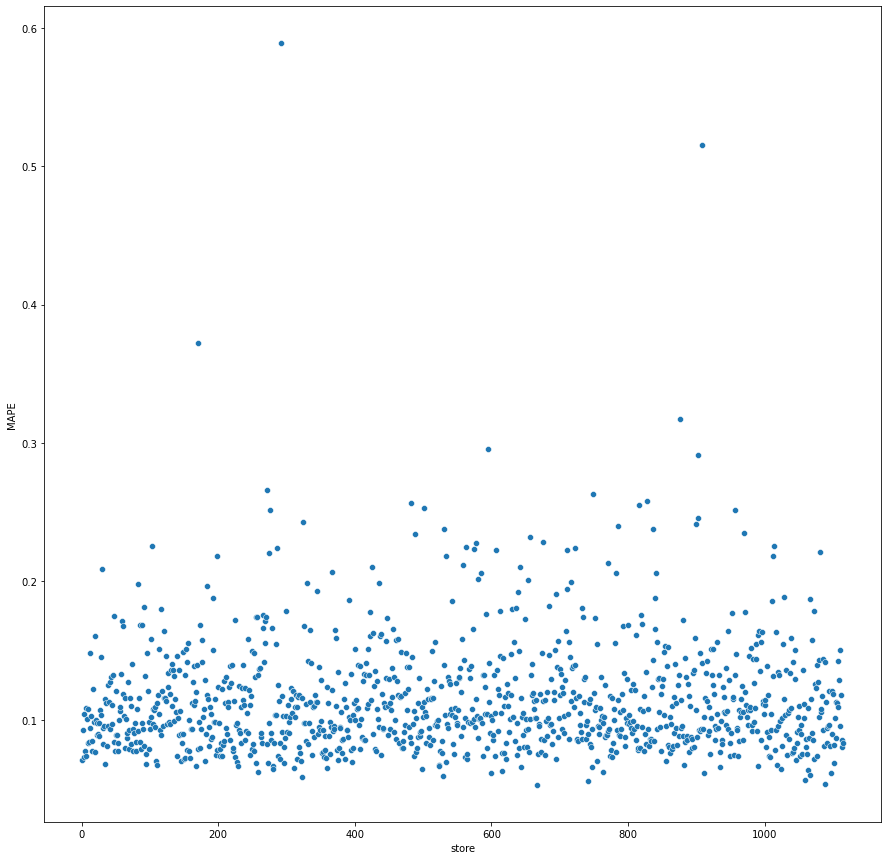

In [81]:
plt.figure(figsize=(15,15))
sns.scatterplot(x='store', y='MAPE', data=df92)
plt.show()

## 9.2 Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map('€{:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"€287,260,416.00"
1,worst_scenario,"€286,409,667.53"
2,best_scenario,"€288,111,145.53"


## 9.3 Machine Learning Performance

In [83]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

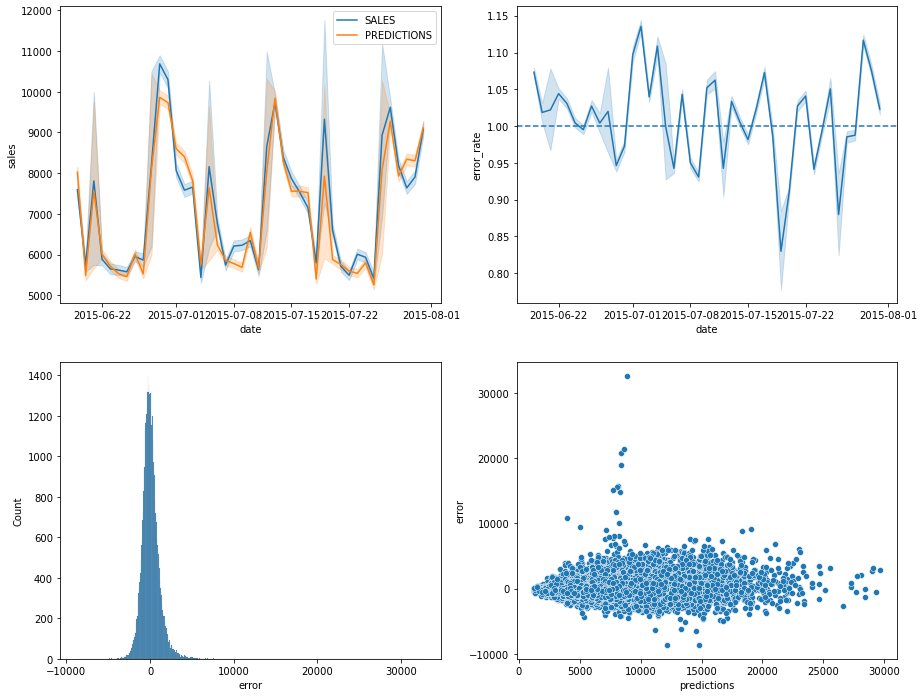

In [84]:
plt.figure(figsize=(15,12))

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.histplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x = df9['predictions'], y= df9['error'] )

plt.show()

# 10.0 Deploy Modelo to Production

In [85]:
# Saved Trained Model

pickle.dump(model_xgb_tuned, open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [86]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann (object):
    def __init__ (self):
        self.competition_distance_scaler   = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/parameter/store_type_scaler.pkl', 'rb'))
    
    
    def data_cleaning (self, df1):
        
        ## 1.1 Rename Columns
        
        columns_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                       'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        columns_new = list(map(snakecase, columns_old))
        
        # Rename
        df1.columns = columns_new
        
        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        
        #competition_distance
        #Assumption: NA means a distant competitor. A replacement will be made for a value above the maximum.
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        #Assumption: The replacement will occur by the value of the month present on the date
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year     
        #Assumption: The replacement will occur by the value of the year present on the date
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)                          

        #promo2_since_week               
        #Assumption: The replacement will occur by the value of the week present on the date
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)                          

        #promo2_since_year               
        #Assumption: The replacement will occur by the value of the week present on the date
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)                          

        #promo_interval
        #Assumption: Assumption: NA means the store has no active promotion. will be replaced by 0.
        #A new feature (is_promo) will be created. In this feature, it will be described if the store has an active promotion.

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

        df1['promo_interval'].fillna( 0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )



        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
        df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
        df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')
        
        return df1
    
    def feature_engineering( self, df2 ):
        
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype('int64')

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #Competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'Public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day' )

        # 3.0 FILTERING VARIABLES

        ## 3.1 Line filtering

        df2 = df2[(df2['open'] != 0)]  

        ## 3.2 Columns selection

        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):     
    
        # 5.0 Data Preparation
        ## 5.2 Rescalling

        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        # year 
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
   

        ## 5.3 Transformação
        ### 5.3.1 Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        #assortment
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        ### 5.3.3 Nature Transformation
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 
                                'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week',
                                'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin',
                                'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 
                                'week_of_year_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        #Prediction
        pred = model.predict(test_data)
        
        #join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [87]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/model/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response
        
    else: 
        return Response( '{}', status=200, mimetype='application/json' )
        
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [88]:
#Loading test dataset
df10 = pd.read_csv('C:/Users/arons/OneDrive/Documentos/com_ds/Repos/03_ds_em_prod/datasets/test.csv')

In [89]:
# Merge Test Dataset + Store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# Choose Store for prediction
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# Remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1 )


In [90]:
# Convert Dataframe to json

data = json.dumps(df_test.to_dict(orient='records'))

In [91]:
# API Call

#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-aseixas.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )



Status Code 200


In [92]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6815.534668
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4192.122070
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,...,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,7839.891113
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6934.649414
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4233.872559


In [93]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range(len(d2)):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store Number 12 will sell R$257,866.53 in the next 6 weeks
Store Number 22 will sell R$155,585.50 in the next 6 weeks
Store Number 24 will sell R$291,574.43 in the next 6 weeks
